Note that one cannot run `vfi_EZ` without changing the CRRA parameter to one greater than 1. However, the grid is still centred around the steady-state capital stock for log utility.

In [29]:
using CairoMakie, LinearAlgebra, Dierckx, Optim

In [51]:
pars1 = (;α = 0.33, # Capital share
         β = 0.9, # Discount factor
         γ = 2.0, # CRRA parameter
         δ = 0.1, # Depreciation rate
         A = 10.0, # TFP
         θ = 3.0, # Expanding grid parameter
         grid_size = 101, # number of gridpoints
         grid_min = 0.75, # minimum gridpoint (multiple of steady state capital stock)
         grid_max = 1.25, # maximum gridpoint (multiple of steady state capital stock)
         lb = 0.7, # lower bound for optimisation
         ub = 1.3, # upper bound for optimisation
         maxiter = 10000, # maximum number of iterations
         toler = 4e-7) # tolerance

(α = 0.33, β = 0.9, γ = 2.0, δ = 0.1, A = 10.0, θ = 3.0, grid_size = 101, grid_min = 0.75, grid_max = 1.25, lb = 0.7, ub = 1.3, maxiter = 10000, toler = 4.0e-7)

In [31]:
function utility(c, pars)
    if pars.γ == 1
        return log(c)
    else
        return (c^(1-pars.γ))/(1-pars.γ)
    end
end

function production(k, kp, pars)
    (;A, α, δ) = pars
    return A*k^α + (1.0-δ)*k - kp
end

function exp_grid(pars)
    (; θ, grid_min, grid_max, grid_size, A, α, β, δ) = pars
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α)) 
    grid = LinRange(0.0, 1.0, grid_size)
    grid = grid_min*Kss .+ (grid_max*Kss .- grid_min*Kss).*grid.^θ
    return grid
end

function interpV(grid, v)
    return Spline1D(grid, v, k=3, bc="extrapolate")
end

function optimise(grid, interp_v, policy, pars)
    (; grid_size, lb, ub, β, A, α, δ) = pars
    v_new = zeros(grid_size)
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α))
    for i in 1:grid_size
        obj(kp) = - (utility(production(grid[i], kp, pars), pars) + β * interp_v(kp))
        res = optimize(obj,Kss*lb,Kss*ub)
        policy[i] = res.minimizer
        v_new[i] = -res.minimum
    end
    return v_new, policy
end

optimise (generic function with 1 method)

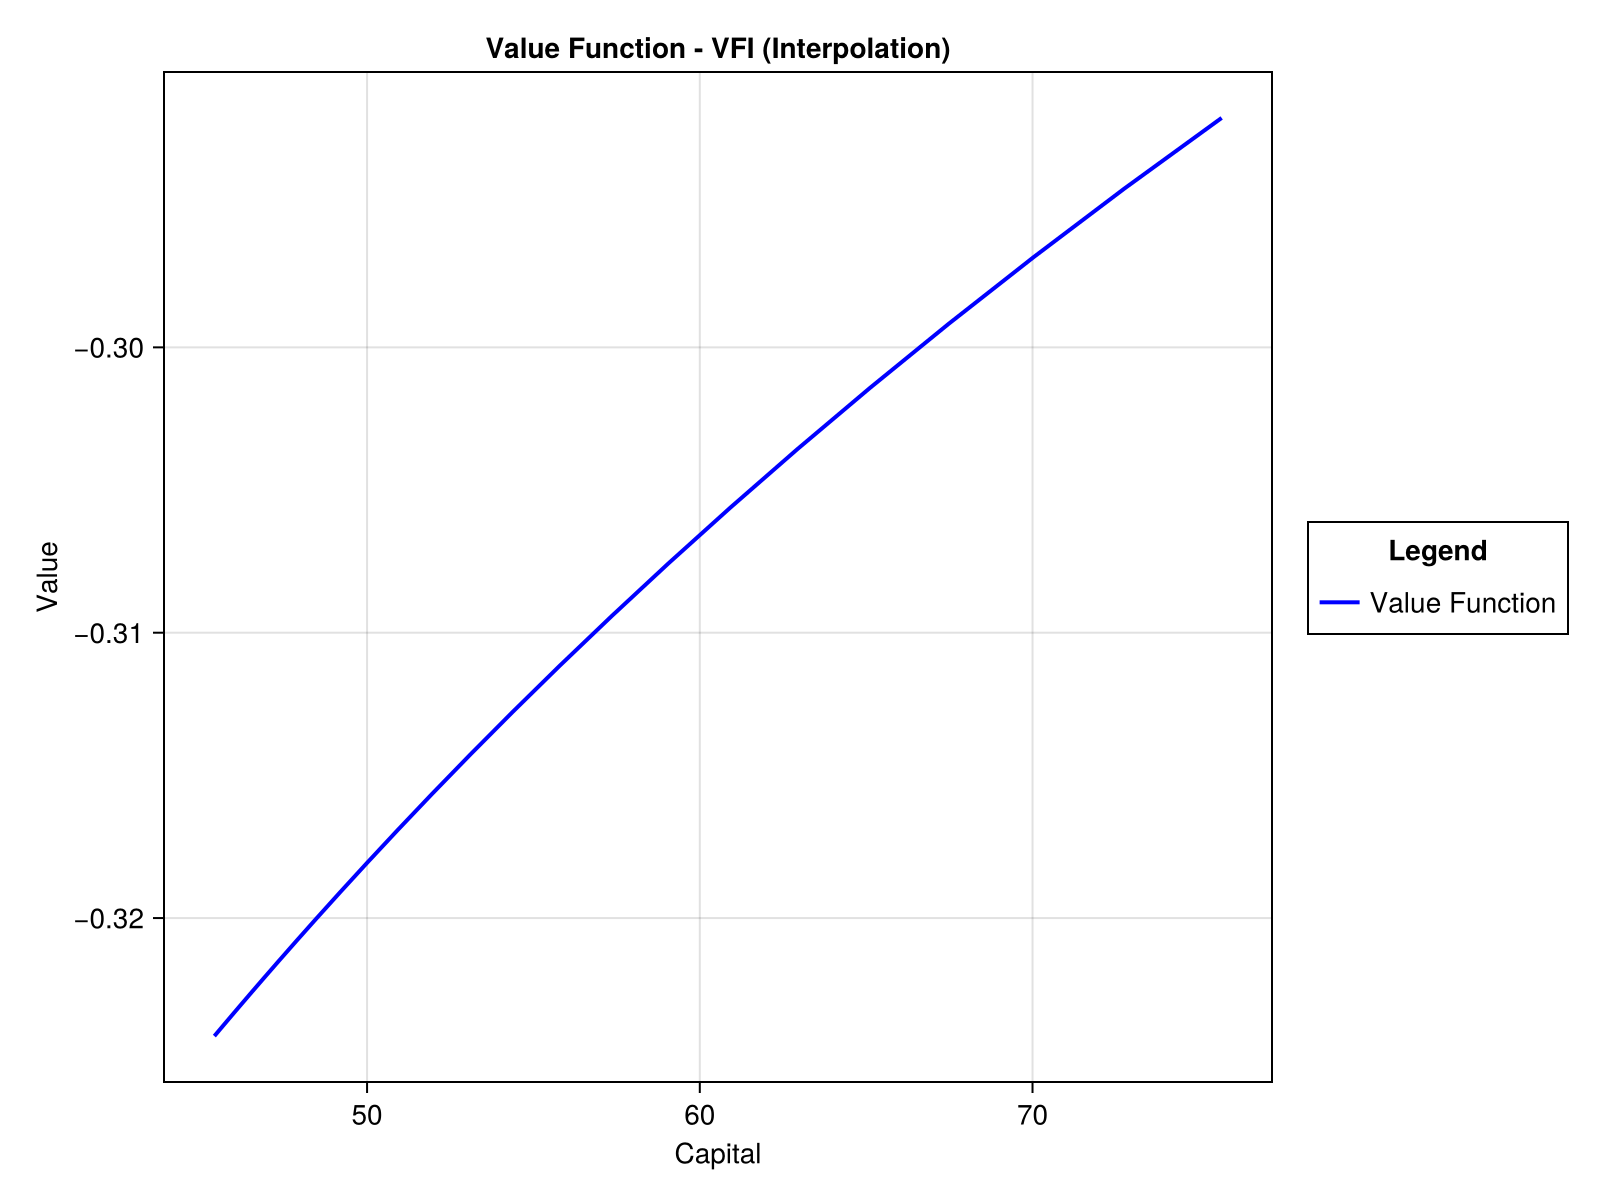

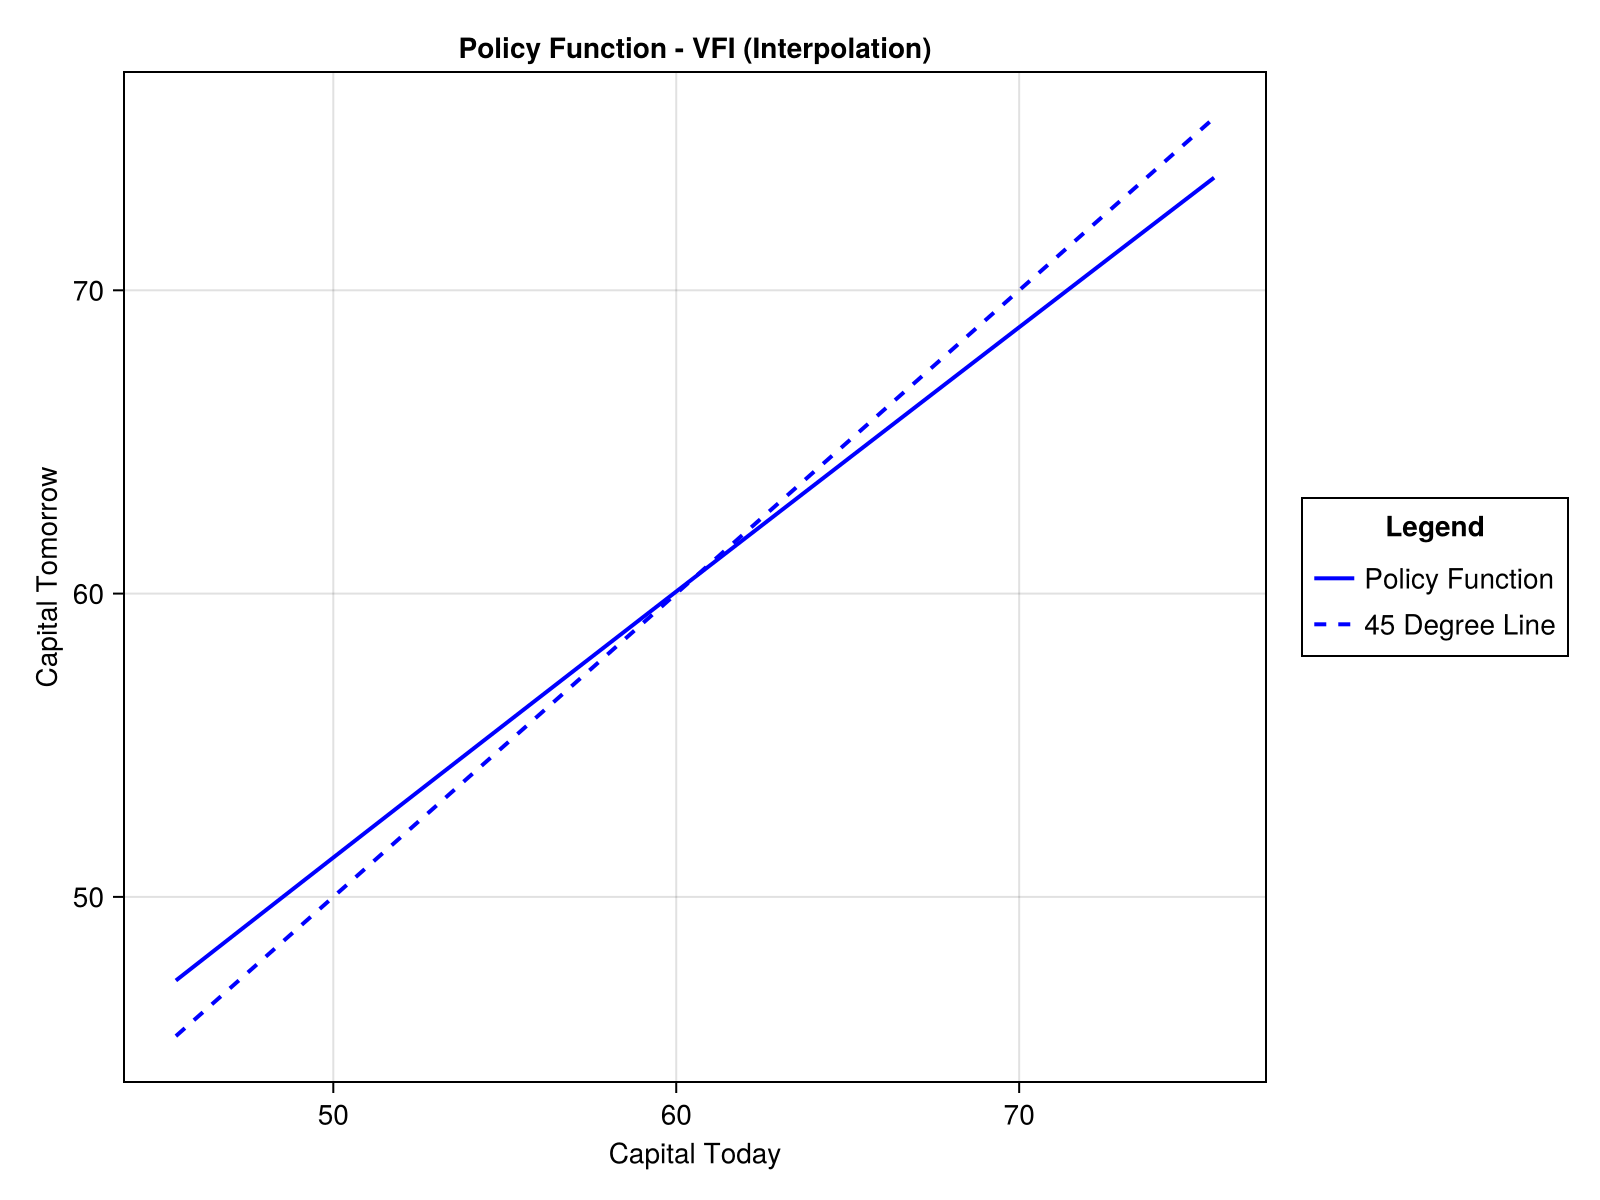

Iterating...
---------------------
Completed iteration 0 with error 0.06932594475456606

---------------------
Completed iteration 10 with error 0.042377208504710044

---------------------
Completed iteration 20 with error 0.014018148877333264

---------------------
Completed iteration 30 with error 0.004518818918904316

---------------------
Completed iteration 40 with error 0.0015351444068953926

---------------------
Completed iteration 50 with error 0.000530514869252584

---------------------
Completed iteration 60 with error 0.00018440716079132588

---------------------
Completed iteration 70 with error 6.422950915133864e-5

---------------------
Completed iteration 80 with error 2.238702869151016e-5

---------------------
Completed iteration 90 with error 7.804851136893602e-6

---------------------
Completed iteration 100 with error 2.7212589206040215e-6

---------------------
Completed iteration 110 with error 9.488291892527715e-7

--------------------
Converged after 120 iterat

(Float32[-0.3241362, -0.32413465, -0.32412374, -0.32409418, -0.32403663, -0.3239419, -0.32380077, -0.3236044, -0.323344, -0.32301122  …  -0.31115258, -0.30941996, -0.30757585, -0.3056243, -0.30357006, -0.3014184, -0.29917517, -0.29684654, -0.294439, -0.2919592], Float32[47.243164, 47.244156, 47.251106, 47.269966, 47.306694, 47.36724, 47.457558, 47.58358, 47.75125, 47.96649  …  56.38797, 57.75044, 59.24078, 60.864502, 62.62709, 64.53404, 66.59084, 68.80284, 71.175766, 73.714226])

In [50]:
function vfi(v, pars)
    (; α, β, δ, grid_size, maxiter, toler, A) = pars
    v_init = ones(grid_size)
    policy = similar(v)
    K = exp_grid(pars)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v = interpV(K, v_init)
        v_new, policy = optimise(K, v, policy, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % 10 == 0
            println("---------------------")
            println("Completed iteration $iter with error $error\n")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged after $iter iterations with error $error\n")
    println("--------------------")

    K = vec(Float32.(K))
    v_init = vec(Float32.(v_init))
    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Function - VFI (Interpolation)", xlabel = "Capital", ylabel = "Value")
    lines!(ax1, K, v_init, color = :blue, linewidth = 2, label = "Value Function")
    legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
    display(fig1)

    policy = vec(Float32.(policy))
    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Function - VFI (Interpolation)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
    lines!(ax2, K, policy, color = :blue, linewidth = 2, label = "Policy Function")
    lines!(ax2, K, K, color = :blue, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
    legend = Legend(fig2[1, 2], ax2, "Legend", orientation = :vertical)
    display(fig2)

    return v_init, policy
end

test_v = zeros(pars.grid_size)
v_out, policy_out = vfi(test_v, pars)

In [47]:
function utility_EZ(c, pars)
    return (c^(1-pars.γ))
end

function production(k, kp, pars)
    (;A, α, δ) = pars
    return A*k^α + (1.0-δ)*k - kp
end

function exp_grid(pars)
    (; θ, grid_min, grid_max, grid_size, A, α, β, δ) = pars
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α)) 
    grid = LinRange(0.0, 1.0, grid_size)
    grid = grid_min*Kss .+ (grid_max*Kss .- grid_min*Kss).*grid.^θ
    return grid
end

function interpV_EZ(grid, v)
    interp = Spline1D(grid, v, k=1, bc="extrapolate")
    transformed_interp(x) = interp(x)^(1.0-pars.γ)
    return transformed_interp
end

function optimise_EZ(grid, interp_v, policy, pars)
    (; grid_size, lb, ub, β, A, α, δ, γ) = pars
    v_new = zeros(grid_size)
    Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α))
    for i in 1:grid_size
        obj_EZ(kp) = - ( (1-β) * utility_EZ(production(grid[i], kp, pars), pars) + β * interp_v(kp))^(1.0/(1.0-γ))
        res = optimize(obj_EZ,Kss*lb,Kss*ub)
        policy[i] = res.minimizer
        v_new[i] = -res.minimum
    end
    return v_new, policy
end

optimise_EZ (generic function with 1 method)

Iterating...
---------------------
Completed iteration 0 with error 0.05181055759547851

---------------------
Completed iteration 100 with error 8.546253941021257e-5

--------------------
Converged after 152 iterations with error 3.967667211197594e-7

--------------------


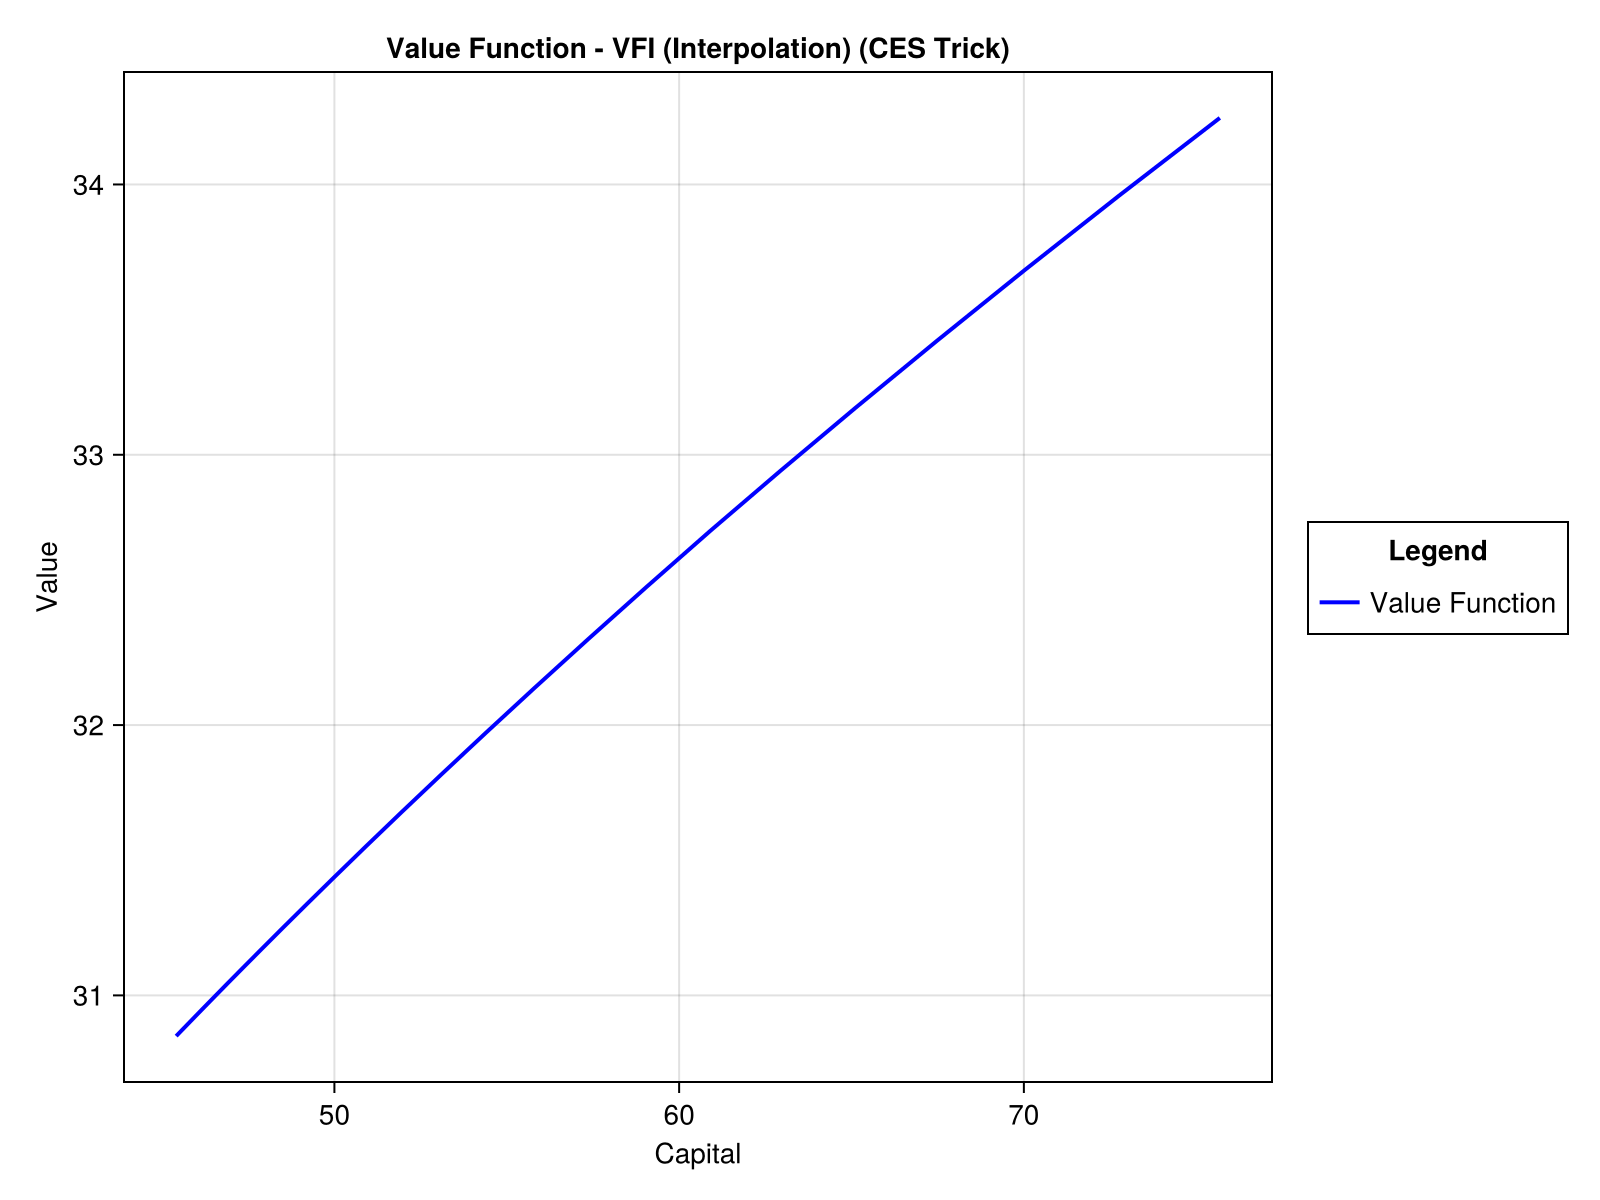

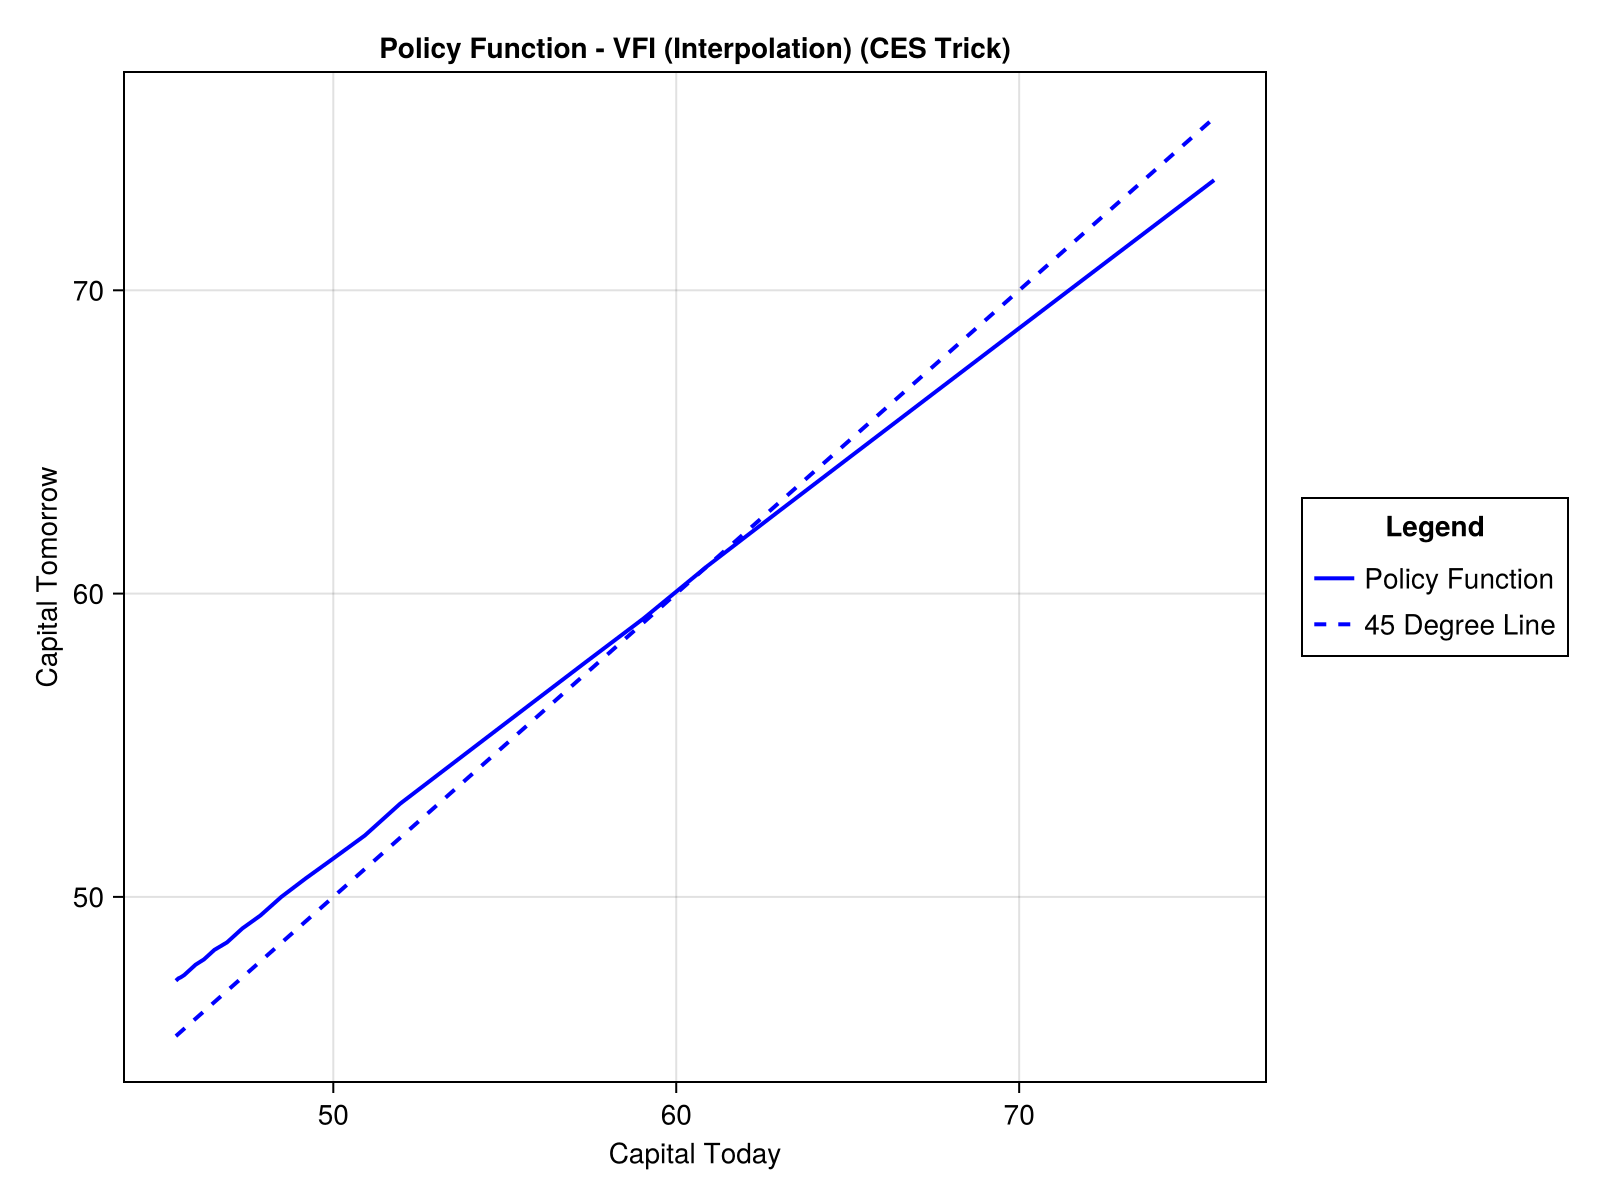

(Float32[30.84942, 30.84957, 30.850607, 30.85342, 30.8589, 30.867928, 30.881342, 30.900051, 30.924932, 30.95679  …  32.136234, 32.316563, 32.510937, 32.719257, 32.939667, 33.173878, 33.42179, 33.68327, 33.95814, 34.246204], Float32[47.23758, 47.23874, 47.24684, 47.268833, 47.311657, 47.34788, 47.422546, 47.56945, 47.764828, 47.938995  …  56.392036, 57.73071, 59.184856, 60.910446, 62.66216, 64.54815, 66.58271, 68.77128, 71.1193, 73.632256])

In [52]:
function vfi_EZ(v, pars)
    (; α, β, δ, grid_size, maxiter, toler, A) = pars
    v_init = ones(grid_size)
    v_new = similar(v)
    policy = similar(v)
    K = exp_grid(pars)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v = interpV_EZ(K, v_init)
        v_new, policy = optimise_EZ(K, v, policy, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % 100 == 0
            println("---------------------")
            println("Completed iteration $iter with error $error\n")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged after $iter iterations with error $error\n")
    println("--------------------")

    K = vec(Float32.(K))
    v_init = vec(Float32.(v_init))
    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Function - VFI (Interpolation) (CES Trick)", xlabel = "Capital", ylabel = "Value")
    lines!(ax1, K, v_init, color = :blue, linewidth = 2, label = "Value Function")
    legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
    display(fig1)

    policy = vec(Float32.(policy))
    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Function - VFI (Interpolation) (CES Trick)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
    lines!(ax2, K, policy, color = :blue, linewidth = 2, label = "Policy Function")
    lines!(ax2, K, K, color = :blue, linestyle = :dash, linewidth = 2, label = "45 Degree Line")
    legend = Legend(fig2[1, 2], ax2, "Legend", orientation = :vertical)
    display(fig2)

    return v_init, policy
end

test_v = zeros(pars.grid_size)
v_EV, pol_EV = vfi_EZ(test_v, pars)